# Welcome to the IMC Hackathon 2025! 🙇

Below are few instructions that we encourage you to read in order to make everybodies time best.

**While BigTech don't take coin for our queries, <br/>
we still have limited resources, <br/>
so please be kind on Miss DB.**

In practice this means the following:
* When experimenting, always apply some kind of `LIMIT` to your queries (eg. `LIMIT 42`)
* When running queries, apply sane `WHERE` constraints (eg. `WHERE measurement_start_time > '2025-01-01' AND measurement_start_time > '2025-02-01'`)
* Use common sense: full scans make it bad for everyone, we don't need to enforce that by monetary incentives, because a "Good User is a Gentle User"

Thank you :)

Your friendly system administrator

~ A.

### Docs
Relevant documentation on accessing and analysing OONI data can be found at the following links:
* OONI Explorer MAT: https://ooni.org/support/ooni-explorer/#measurement-aggregation-toolkit-mat
* Interpreting OONI Data: https://ooni.org/support/interpreting-ooni-data/
* OONI base data format specifications: https://github.com/ooni/spec/tree/master/data-formats
* OONI Test specifications: https://github.com/ooni/spec/tree/master/nettests
* OONI Database schema: https://docs.ooni.org/data/oonidata-analysis-db/ Fetching OONI data from Amazon S3: https://docs.ooni.org/data/ 

In [97]:
import numpy as np
import pandas as pd
import altair as alt
from tqdm import tqdm
import matplotlib.pyplot as plt

tqdm.pandas()

from clickhouse_driver import Client as Clickhouse
from uuid import uuid4
from pathlib import Path

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
alt.data_transformers.disable_max_rows()

def click_query(q, params=None):
    click = Clickhouse("localhost")
    query_id = f"oonidata-{uuid4()}"
    print(f"Starting query with id: {query_id} :)")
    return click.query_dataframe(q, params=params, query_id=query_id)

In [119]:
df_sample_obs_web = click_query("""
SELECT
    report_id,
    COUNT(*) AS total_rows,
    COUNTIf(tls_failure IS NOT NULL) AS failed_tls_count,
    COUNTIf(tls_echconfig IS NOT NULL) AS echconfig_count,
    groupArray(DISTINCT tls_echconfig) AS dist_tls_echconfig,
    any(probe_cc) AS probe_country,
    min(measurement_start_time) AS first_seen
FROM obs_web
WHERE test_name = 'echcheck'
  AND measurement_start_time >= '2024-12-01'
  AND probe_cc = 'RU'
GROUP BY report_id
HAVING failed_tls_count = 2
ORDER BY report_id
""")

Starting query with id: oonidata-7b465b11-ffa6-46d0-bf89-d0c9750aa2c3 :)


In [120]:
df_all_obs_web = click_query("""
SELECT
    report_id,
    min(measurement_start_time) AS first_seen
FROM obs_web
WHERE test_name = 'echcheck'
  AND measurement_start_time >= '2024-12-01'
  AND probe_cc = 'RU'
GROUP BY report_id
ORDER BY report_id
""")

Starting query with id: oonidata-45693f19-cf2e-4e5c-aba1-2e97c189245a :)


In [145]:
def draw_ctr(df_sample_obs_web, df_all_obs_web):
    # Ensure first_seen is datetime
    df_sample_obs_web['first_seen'] = pd.to_datetime(df_sample_obs_web['first_seen'], errors='coerce')
    df_all_obs_web['first_seen'] = pd.to_datetime(df_all_obs_web['first_seen'], errors='coerce')
    
    # Assuming df_sample_obs_web contains measurement_start_time and report_id
    df_sample_obs_web['day_bucket'] = df_sample_obs_web['first_seen'].dt.floor('D')
    daily_counts_sample = df_sample_obs_web.groupby('day_bucket')['report_id'].nunique().reset_index()

    
    df_all_obs_web['day_bucket'] = df_all_obs_web['first_seen'].dt.floor('D')
    daily_counts_all = df_all_obs_web.groupby('day_bucket')['report_id'].nunique().reset_index()
    plt.figure(figsize=(12, 5))
    
    # Rename the report_id columns for clarity
    daily_counts_sample = daily_counts_sample.rename(columns={'report_id': 'sample_count'})
    daily_counts_all = daily_counts_all.rename(columns={'report_id': 'all_count'})
    
    # Merge on day_bucket
    daily_merged = pd.merge(daily_counts_all, daily_counts_sample, on='day_bucket', how='left')
    
    # Fill NaN (days with no sample) with 0
    daily_merged['sample_count'] = daily_merged['sample_count'].fillna(0)
    
    # Calculate percentage
    daily_merged['percentage'] = (daily_merged['sample_count'] / daily_merged['all_count']) * 100
    
    # plt.plot(daily_counts_sample['day_bucket'], daily_counts_sample['report_id'], marker='o')
    # plt.plot(daily_counts_all['day_bucket'], daily_counts_all['report_id'], marker='o', color="red")
    plt.plot(daily_merged['day_bucket'], daily_merged['percentage'], marker='o', color="blue")
    
    plt.xlabel('Day')
    plt.ylabel('Percentage of measurements showing ECN Blocking')
    plt.title('Percentage of measurements showing ECN Blocking per day')
    plt.ylim(ymin=0)
    plt.grid(True)
    plt.show()

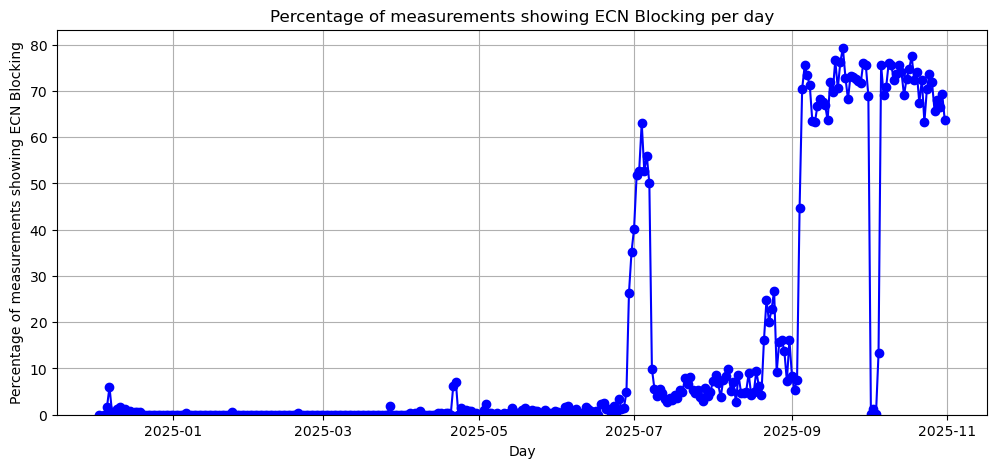

In [146]:
draw_ctr(df_sample_obs_web, df_all_obs_web)

In [129]:
df_sample_obs_web_cn = click_query("""
SELECT
    report_id,
    COUNT(*) AS total_rows,
    COUNTIf(tls_failure IS NOT NULL) AS failed_tls_count,
    COUNTIf(tls_echconfig IS NOT NULL) AS echconfig_count,
    groupArray(DISTINCT tls_echconfig) AS dist_tls_echconfig,
    any(probe_cc) AS probe_country,
    min(measurement_start_time) AS first_seen
FROM obs_web
WHERE test_name = 'echcheck'
  AND measurement_start_time >= '2024-12-01'
  AND probe_cc = 'CN'
GROUP BY report_id
HAVING failed_tls_count = 2
ORDER BY report_id
""")

Starting query with id: oonidata-b26f8417-26ea-426a-aec9-61ad2a1c0f4f :)


In [130]:
df_all_obs_web_cn = click_query("""
SELECT
    report_id,
    min(measurement_start_time) AS first_seen
FROM obs_web
WHERE test_name = 'echcheck'
  AND measurement_start_time >= '2024-12-01'
  AND probe_cc = 'CN'
GROUP BY report_id
ORDER BY report_id
""")

Starting query with id: oonidata-9a85a4df-06e9-4631-82c3-58dac8f003d6 :)


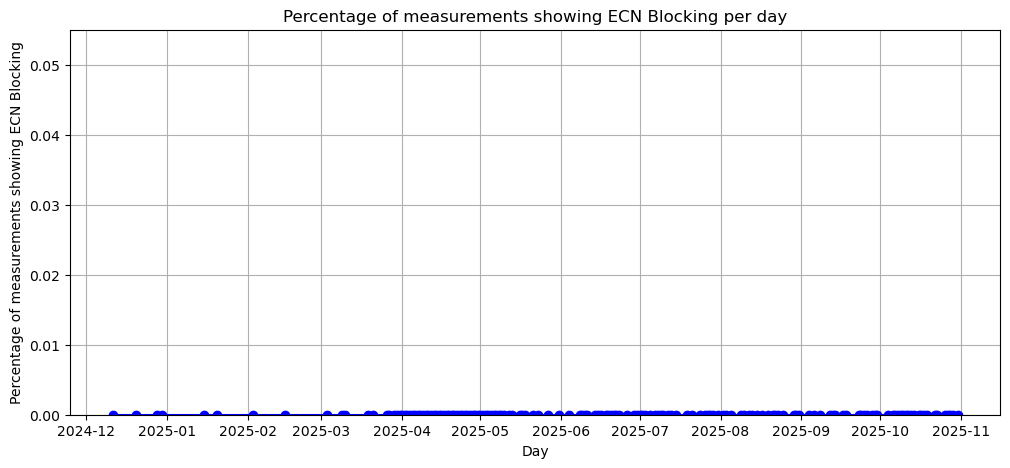

In [147]:
draw_ctr(df_sample_obs_web_cn, df_all_obs_web_cn)

In [140]:
df_all_obs_web_in = click_query("""
SELECT
    report_id,
    min(measurement_start_time) AS first_seen
FROM obs_web
WHERE test_name = 'echcheck'
  AND measurement_start_time >= '2024-12-01'
  AND probe_cc = 'IN'
GROUP BY report_id
ORDER BY report_id
""")
df_sample_obs_web_in = click_query("""
SELECT
    report_id,
    COUNT(*) AS total_rows,
    COUNTIf(tls_failure IS NOT NULL) AS failed_tls_count,
    COUNTIf(tls_echconfig IS NOT NULL) AS echconfig_count,
    groupArray(DISTINCT tls_echconfig) AS dist_tls_echconfig,
    any(probe_cc) AS probe_country,
    min(measurement_start_time) AS first_seen
FROM obs_web
WHERE test_name = 'echcheck'
  AND measurement_start_time >= '2024-12-01'
  AND probe_cc = 'IN'
GROUP BY report_id
HAVING failed_tls_count = 2
ORDER BY report_id
""")

Starting query with id: oonidata-d0cca6e1-768a-4784-bda1-6edfb532ae1e :)
Starting query with id: oonidata-48dde0b7-2975-4fe8-b868-08811e614a9e :)


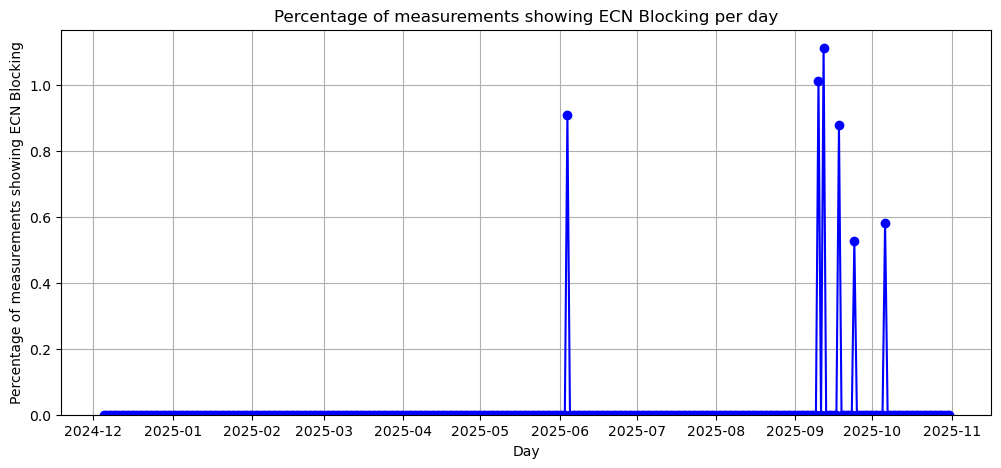

In [148]:
draw_ctr(df_sample_obs_web_in, df_all_obs_web_in)

In [144]:
display(df_all_obs_web_in)

,report_id,first_seen,day_bucket
0,20241205T193723Z_echcheck_IN_136334_n1_84iTmEm...,2024-12-05 19:37:23+00:00,2024-12-05 00:00:00+00:00
1,20241205T194044Z_echcheck_IN_136334_n1_ekYqMRy...,2024-12-05 19:40:44+00:00,2024-12-05 00:00:00+00:00
2,20241206T002116Z_echcheck_IN_55836_n1_cxsf1vM2...,2024-12-06 00:21:16+00:00,2024-12-06 00:00:00+00:00
3,20241206T023142Z_echcheck_IN_24560_n1_aMrf2cAL...,2024-12-06 02:31:41+00:00,2024-12-06 00:00:00+00:00
4,20241206T024338Z_echcheck_IN_24560_n1_hWcswgln...,2024-12-06 02:43:37+00:00,2024-12-06 00:00:00+00:00
...,...,...,...
33992,20251031T211430Z_echcheck_IN_17488_n4_v92lbciy...,2025-10-31 21:14:30+00:00,2025-10-31 00:00:00+00:00
33993,20251031T212650Z_echcheck_IN_17488_n4_A3CralNa...,2025-10-31 21:26:50+00:00,2025-10-31 00:00:00+00:00
33994,20251031T212709Z_echcheck_IN_134033_n4_WyEd8zj...,2025-10-31 21:27:10+00:00,2025-10-31 00:00:00+00:00
33995,20251031T214253Z_echcheck_IN_9829_n4_ZKa9g08wr...,2025-10-31 21:42:53+00:00,2025-10-31 00:00:00+00:00
